## Model 6:
 - 150 x 150 x 3
 - mini_batch size = 256
 - 20 epochs
 - pretrained layers with mobile net v2
 - +6 top layers

In [1]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import os
from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [15]:
base_directory = "../skin-cancer-mnist-ham10000"

test_directory = os.path.join(base_directory, 'image_data_test')
train_directory = os.path.join(base_directory, 'image_data_train')
validation_directory = os.path.join(base_directory, 'image_data_validation')
bal_validation_directory = os.path.join(base_directory, 'image_data_validation_balanced')

In [3]:
from keras.applications import MobileNetV2

In [5]:
prior = MobileNetV2(include_top =  False, weights = "imagenet", input_shape = (150, 150, 3))

In [6]:
model = Sequential()

model.add(prior)

model.add(Flatten())
# model.add(Dropout(rate = 0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(rate = 0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))

for layer in model.layers[0].layers:
    layer.trainable = False

W0825 15:16:54.026515 4417967552 deprecation.py:506] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16384512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [11]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['acc'])

W0825 15:17:43.253156 4417967552 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range= 90,
                                   width_shift_range= 0.2,
                                   height_shift_range= 0.2,
                                   shear_range= 0.2,
                                   horizontal_flip= True,
                                   vertical_flip= True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=(150, 150), 
        batch_size= 256,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        bal_validation_directory,
        target_size=(150, 150),
        batch_size= 256,
        class_mode='categorical')

Found 5008 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [17]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (256, 150, 150, 3)
labels batch shape: (256, 7)


In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor= "val_loss", patience = 5, restore_best_weights= True),
             ReduceLROnPlateau(monitor="loss", patience = 2)]


In [19]:
class_weights = {
    0: 20.4,
    1: 13,
    2: 6.1,
    3: 57.8,
    4: 1,
    5: 47.2,
    6: 6
}

In [21]:
import numpy as np

history = model.fit_generator(
      train_generator,
      steps_per_epoch=np.ceil(5007/256),
      epochs=20,
      validation_data=validation_generator,
      validation_steps= np.ceil(196/256),
      callbacks= callbacks,
      class_weight= class_weights
)

W0825 15:28:26.196153 4417967552 deprecation.py:323] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
20/20 [==============================] - 347s 17s/step - loss: 14.7681 - acc: 0.1647 - val_loss: 1.9628 - val_acc: 0.2041
Epoch 2/20
20/20 [==============================] - 330s 17s/step - loss: 9.7860 - acc: 0.1898 - val_loss: 1.8606 - val_acc: 0.2296
Epoch 3/20
20/20 [==============================] - 231s 12s/step - loss: 9.2264 - acc: 0.2285 - val_loss: 1.7917 - val_acc: 0.3214
Epoch 4/20
20/20 [==============================] - 218s 11s/step - loss: 8.6896 - acc: 0.2658 - val_loss: 1.7285 - val_acc: 0.3010
Epoch 5/20
20/20 [==============================] - 242s 12s/step - loss: 8.5361 - acc: 0.2478 - val_loss: 1.7287 - val_acc: 0.3061
Epoch 6/20
20/20 [==============================] - 217s 11s/step - loss: 8.4332 - acc: 0.3252 - val_loss: 1.6344 - val_acc: 0.3520
Epoch 7/20
20/20 [==============================] - 236s 12s/step - loss: 7.9845 - acc: 0.3324 - val_loss: 1.5684 - val_acc: 0.3827
Epoch 8/20
20/20 [==============================] - 222s 11s/step - loss: 7

In [22]:
model.save("model_6.h5")

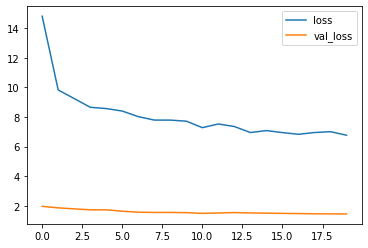

In [23]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend();

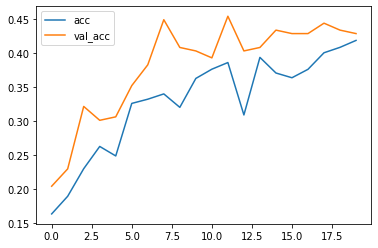

In [24]:
plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["val_acc"], label = "val_acc")
plt.legend();